In [1]:
import nltk
import numpy as np
from pathlib import Path
import glob
import tensorflow as tf
from collections import Counter

In [63]:
data = Path('./aclImdb/')
vocab_path = data / 'imdb.vocab'
n_words = 2000 # only pick the top n words for memory limits

vocab = {}

# mapping word to index
with open(vocab_path, 'r') as f:
    for idx, word in enumerate(f):
        if idx == n_words:
            break
    
        vocab[word.rstrip()] = idx
        
    
reverse_vocab = {v:k for (k, v) in vocab.items()}

In [3]:
# read actual reviews
def read_file(file_path):
    """ read a single file, and return a single 
    list of its encoded version"""
    with open(file_path, 'r') as f:
        content = f.read()
        
    content = content.split() # simply spliting on space and newlines
    encoded_content = []
    for word in content:
        word = word.strip().lower()
        if vocab.get(word, -1) >= 0:
            encoded_content.append(vocab.get(word))
    return encoded_content



all_paths = glob.glob('./aclImdb/train/pos/*.txt') + glob.glob('./aclImdb/train/neg/*.txt')
# don't read in all the text at once, hits the memory too hard
# corpus = [read_file(f) for f in all_paths]

In [4]:
def get_neighbour_pairs(content):
    """ return the neighbour words in the format of (source word list, neighbour word list)"""
    if len(content) < 2:
        return [], []
    start_list, neighbour_list = [], []
    for i in range(1, len(content)-1):
        start_list.extend([content[i]] * 2)
        neighbour_list.append(content[i-1])
        neighbour_list.append(content[i+1])
    
    # add in corner cases
    start_list.append(content[0])
    neighbour_list.append(content[1])
    return start_list, neighbour_list

In [5]:
n_vocab = len(vocab)
cooccurence_matrix = np.zeros([n_vocab, n_vocab], dtype=np.int32)

for file_path in all_paths:
    content = read_file(file_path)
    s, n = get_neighbour_pairs(content)
    cooccurence_matrix[s, n] += 1

In [6]:
# calculate the probability by Xij / sum(Xi)
cooccurence_matrix = cooccurence_matrix / np.sum(cooccurence_matrix + 1e-10, axis=1)
cooccurence_matrix = cooccurence_matrix.astype(np.float32)

In [7]:
co_matrix = {}

for i in range(n_vocab):
    for j in range(n_vocab):
        co_matrix[(i, j)] = cooccurence_matrix[i, j]
    
del cooccurence_matrix
del vocab

In [21]:
batch_size = 512
_scaling_factor = 3/4
cooccurence_cap = 100
learning_rate = 0.05

In [50]:
tf.reset_default_graph()

count_max = tf.constant([cooccurence_cap], dtype=tf.float32)
scaling_factor = tf.constant([_scaling_factor], dtype=tf.float32)

focal_input = tf.placeholder(tf.int32, [batch_size])
context_input = tf.placeholder(tf.int32, [batch_size])
co_count = tf.placeholder(tf.float32, [batch_size])

embedding_u = tf.get_variable('embedding_u', [n_vocab, 100], 
                              initializer=tf.random_uniform_initializer(-1., 1.))
embedding_v = tf.get_variable('embedding_v', [n_vocab, 100], 
                              initializer=tf.random_uniform_initializer(-1., 1.))


# focal_bias = tf.get_variable('focal_bias', [100], 
#                             initializer=tf.random_uniform_initializer(-1., 1.))
# context_bias = tf.get_variable('context_bias', [100], 
#                             initializer=tf.random_uniform_initializer(-1., 1.))

focal_embedding = tf.nn.embedding_lookup(embedding_u, focal_input)
context_embedding = tf.nn.embedding_lookup(embedding_v, context_input)

weighting_factor = tf.minimum(1.0, tf.pow(tf.div(co_count, count_max), scaling_factor))
embedding_product = tf.reduce_sum(focal_embedding * context_embedding, 1)
log_co = tf.log1p(co_count)

loss = weighting_factor * tf.squared_difference(embedding_product, log_co)
loss = tf.reduce_sum(loss)

optimizer = tf.train.AdamOptimizer(0.005).minimize(loss)

In [40]:
co_list = [(w[0], w[1], c) for (w, c) in co_matrix.items()]
del co_matrix

In [51]:
def data_generator(n_epochs=2, batch_size=512):
    global co_list
    n_steps = int(len(co_list) / batch_size) * n_epochs
    
    for _ in range(n_steps):
        batch = co_list[:batch_size]
        focal = [x[0] for x in batch]
        context = [x[1] for x in batch]
        count = [x[2] for x in batch]
        yield (focal, context, count)
        co_list = np.roll(co_list, batch_size)    

In [55]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i, (focal, context, count) in enumerate(data_generator(2)):
        feed_dict = {focal_input:focal, context_input:context, co_count:count}
        _, l = sess.run([optimizer, loss], feed_dict=feed_dict)
        
        if (i % 100 == 0):
            print('Loss at row {} = {}'.format(i, l))
            
        if (i % 1000 == 0):
            saver.save(sess, './model/Glove', i)

Loss at row 0 = 0.02977755106985569
Loss at row 100 = 3969.29541015625
Loss at row 200 = 42832.2265625
Loss at row 300 = 0.03208819404244423
Loss at row 400 = 3.4111504554748535
Loss at row 500 = 20195.083984375
Loss at row 600 = 0.032769154757261276
Loss at row 700 = 6.979071617126465
Loss at row 800 = 240.245361328125
Loss at row 900 = 0.004659126978367567
Loss at row 1000 = 6.628458023071289
Loss at row 1100 = 5467.4873046875
Loss at row 1200 = 0.1177603155374527
Loss at row 1300 = 9.008085250854492
Loss at row 1400 = 659.3637084960938
Loss at row 1500 = 0.06342776119709015
Loss at row 1600 = 14.818929672241211
Loss at row 1700 = 1216.117431640625
Loss at row 1800 = 0.07546643912792206
Loss at row 1900 = 3.7527525424957275
Loss at row 2000 = 25665.849609375
Loss at row 2100 = 0.03690009191632271
Loss at row 2200 = 8.261280059814453
Loss at row 2300 = 660.91796875
Loss at row 2400 = 0.07556961476802826
Loss at row 2500 = 4.6227006912231445
Loss at row 2600 = 12496.20703125
Loss at ro

In [62]:
ckpt = tf.train.get_checkpoint_state('./model')
with tf.Session() as sess:
    saver.restore(sess, ckpt.model_checkpoint_path)
    e_u = embedding_u.eval()
    e_v = embedding_v.eval()
    
embedding = e_u + e_v

INFO:tensorflow:Restoring parameters from ./model/Glove-15000


In [65]:
# visualization

from sklearn.manifold import TSNE

embedding_2d = TSNE(2).fit_transform(embedding)

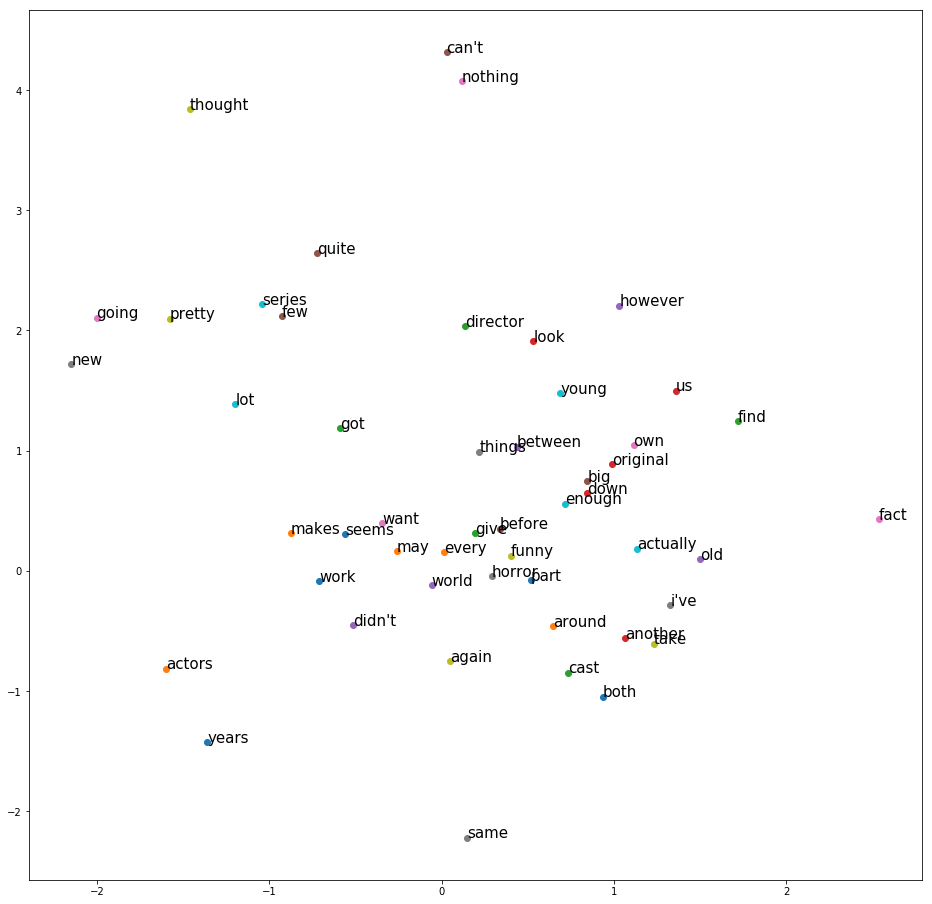

In [77]:
import matplotlib.pyplot as plt
%matplotlib inline


_ = plt.figure(figsize=(16, 16))
for i in range(150, 200):
    word = reverse_vocab[i]
    x, y = embedding_2d[i, :]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), size=15)